In [2]:
# source (https://www.kaggle.com/shrishc/time-series-analysis-bitcoin-price-prediction)
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import boxcox

from itertools import product
from numpy.linalg import LinAlgError
from keras.layers import LSTM


Using TensorFlow backend.


In [3]:
df = pd.read_csv('E:\\bitstamp20120101to20190313.csv')  

#just a few basic steps
print(df.head())
print(df.shape)
print(df.describe())
print(df.isnull().any())

    Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
(3778817, 8)
          Timestamp          Open          High           Low         Close  \
count  3.778817e+06  2.551132e+06  2.551132e+06  2.551132e+06  2.551132e+06   
mean   1.438908e+09  2.654668e+03  2.656783e+03  2.652286e+03  2.654650e+03   
std    6.561491e+07  3.529553e+03  3.533184e+03  3.525347e+03  3.529522e+03   
min    1.325318e+09  3.800000e+00  3.800000e+00  1.500000e+00  1.500000e+00   
25%    1.382000e+09  

In [4]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit = 's')
df.index = df.Timestamp
df = df.resample('M').mean()

In [5]:
print(df.describe())
df.isnull().any()
prices = df.Weighted_Price

               Open          High           Low         Close  Volume_(BTC)  \
count     88.000000     88.000000     88.000000     88.000000     88.000000   
mean    1900.892240   1902.353666   1899.251046   1900.881271     12.062964   
std     3093.687291   3096.793892   3090.118478   3093.656310      6.693010   
min        4.465000      4.482500      4.465000      4.482500      3.106413   
25%      147.161983    147.294605    147.009761    147.154860      6.885398   
50%      461.700852    462.062648    461.331893    461.707544     10.348770   
75%     2036.870206   2038.716073   2034.822901   2036.831152     15.408577   
max    14843.232528  14865.433509  14815.368545  14843.091403     31.504424   

       Volume_(Currency)  Weighted_Price  
count          88.000000       88.000000  
mean        16945.735344     1900.784140  
std         31619.386662     3093.448192  
min            25.168238        4.471603  
25%          1594.231954      147.150454  
50%          4743.817607      

c:\users\voidmain1\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


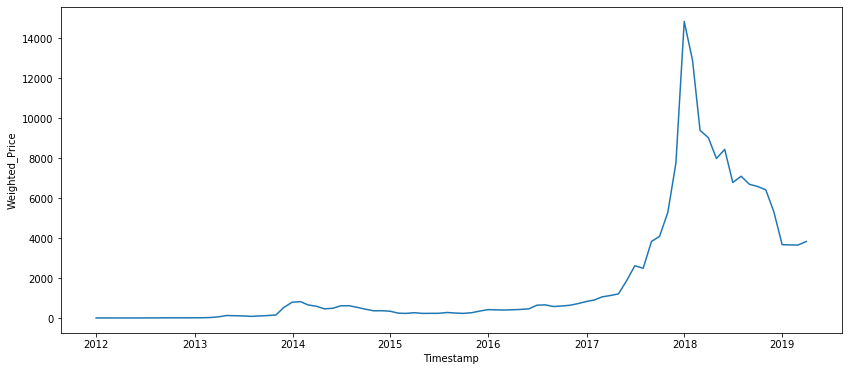

In [6]:
plt.figure(figsize = (14,6))
sns.lineplot(x = df.index, y = prices)

In [7]:
def decompose(series):
    plt.figure(figsize = (14,7))
    seasonal_decompose(series).plot()
    plt.show()
    
def DFTest(series):
    testdf = adfuller(series)
    print("DF test p-value : %.16f" %testdf[1] )
    
    
def plots(series):
    plt.figure(figsize = (10,6))
    sns.lineplot(data = series, color = 'blue', label = 'observed line plot')
    sns.lineplot(data = series.rolling(window = 12).mean(), color = 'green', label = 'rolling mean, window -12')
    sns.lineplot(data = series.rolling(window = 12).std(), color = 'black', label = 'std deviation, window -12')


DF Test->
DF test p-value : 0.3627748023414656


<Figure size 1008x504 with 0 Axes>

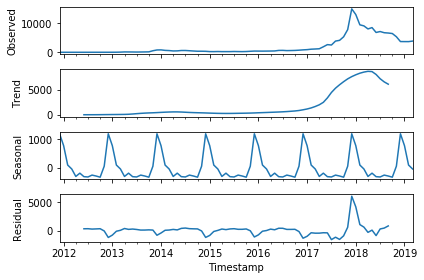

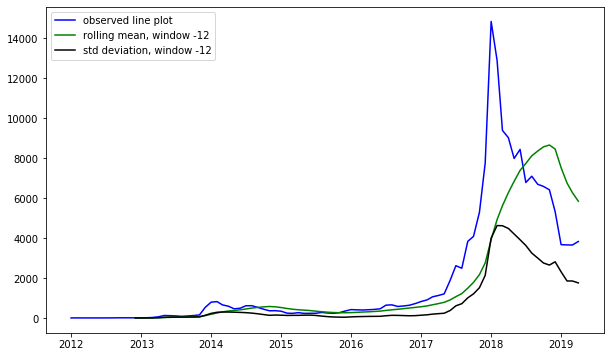

In [8]:
print("DF Test->")
#running tests
DFTest(prices)
decompose(prices)
plots(prices)

DF test p-value : 0.4949716613444953


<Figure size 1008x504 with 0 Axes>

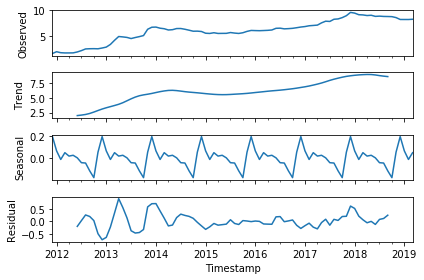

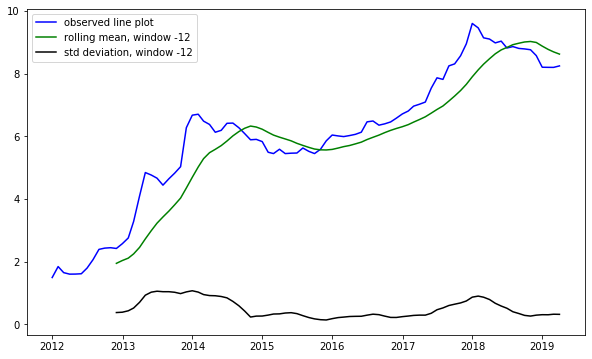

In [9]:
prices_log = np.log(prices)

#running tests
DFTest(prices_log)
decompose(prices_log)
plots(prices_log)

DF test p-value : 0.0000002338762606


<Figure size 1008x504 with 0 Axes>

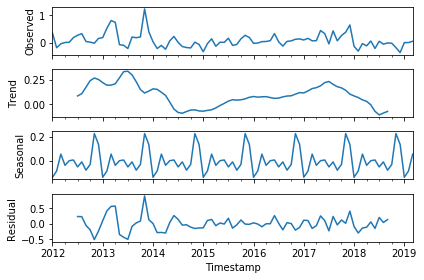

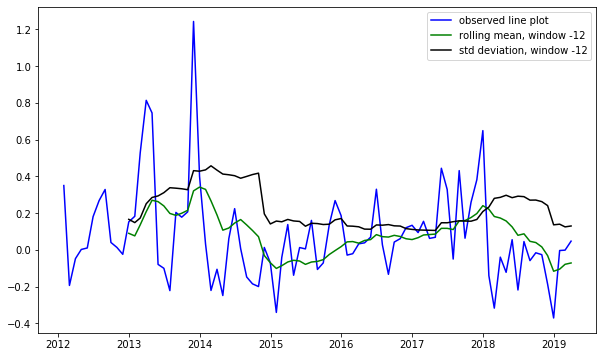

In [10]:
#prices_log with regular shift transform
prices_log_r = prices_log - prices_log.shift(1)
prices_log_r.dropna(inplace = True)

DFTest(prices_log_r)
decompose(prices_log_r)
plots(prices_log_r)

<Figure size 1008x504 with 0 Axes>

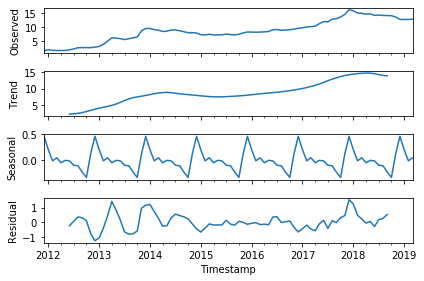

DF test p-value : 0.6005243678350998
lambda value: 0.10079832726303456


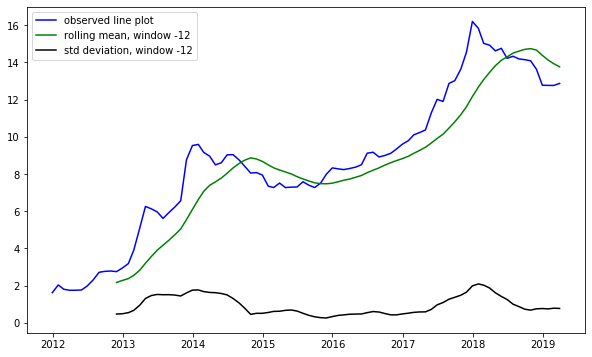

In [11]:
prices_box_cox_, lambda_ = boxcox(prices)
prices_box_cox = pd.Series(data = prices_box_cox_, index = df.index) #decompose functions requires a pandas object that has a timestamp index.

decompose(prices_box_cox) 
DFTest(prices_box_cox)
print('lambda value:', lambda_)
plots(prices_box_cox)

<Figure size 1008x504 with 0 Axes>

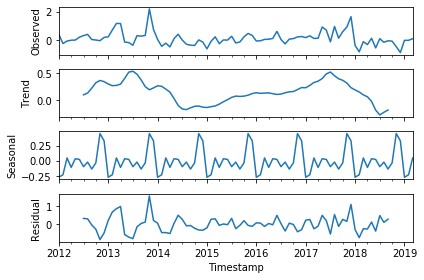

DF test p-value : 0.0000000920859274


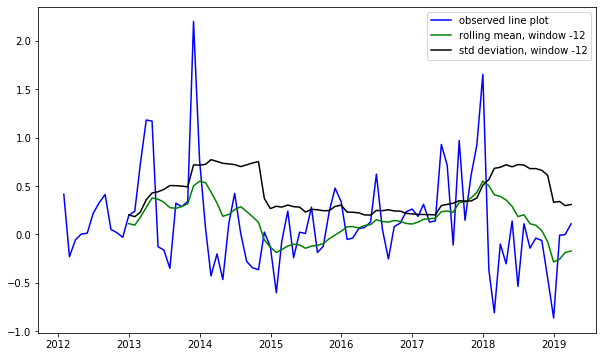

In [12]:
prices_box_cox_r = prices_box_cox - prices_box_cox.shift(1)
prices_box_cox_r.dropna(inplace = True)

decompose(prices_box_cox_r) 
DFTest(prices_box_cox_r)
plots(prices_box_cox_r)

c:\users\voidmain1\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


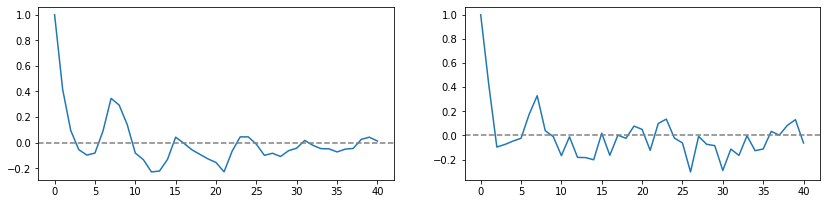

In [13]:
plt.figure(figsize = (14,7)) 
a = acf(prices_log_r)
p = pacf(prices_log_r)

plt.subplot(221)
sns.lineplot(data = a)
plt.axhline(y=0, linestyle='--', color='gray')

plt.subplot(222)
sns.lineplot(data = p)
plt.axhline(y=0, linestyle='--', color='gray')

c:\users\voidmain1\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 1, 2) -2.32519863872335
[[(1, 1, 1), -0.8414832864019957], [(1, 1, 2), 0.8408114961878255], [(1, 1, 3), 2.7850575943700733], [(2, 1, 1), 0.5412023032175739], [(2, 1, 2), 0.9084663039672023], [(2, 1, 3), -1.4591885278490508], [(3, 1, 1), 2.4026583048968746], [(3, 1, 2), -2.32519863872335], [(3, 1, 3), -0.4801058538042753]]
Timestamp
2012-01-31    0.082998
2012-02-29    0.193884
2012-03-31   -0.076529
2012-04-30    0.021005
2012-05-31    0.068960
2012-06-30    0.086811
2012-07-31    0.164231
2012-08-31    0.178768
2012-09-30    0.168608
2012-10-31    0.009290
2012-11-30    0.003642
2012-12-31    0.013954
2013-01-31    0.126527
2013-02-28    0.156678
2013-03-31    0.304038
2013-04-30    0.387443
2013-05-31    0.298712
2013-06-30   -0.083951
2013-07-31   -0.036258
2013-08-31   -0.014358
2013-09-30    0.230241
2013-10-31    0.218720
2013-11-30    0.195061
2013-12-31    0.560776
2014-01-31    0.080269
2014-02-28   -0.094365
2014-03-31   -0.136091
2014-04-30    0.023393
2014-05-31    0.05

c:\users\voidmain1\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\users\voidmain1\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


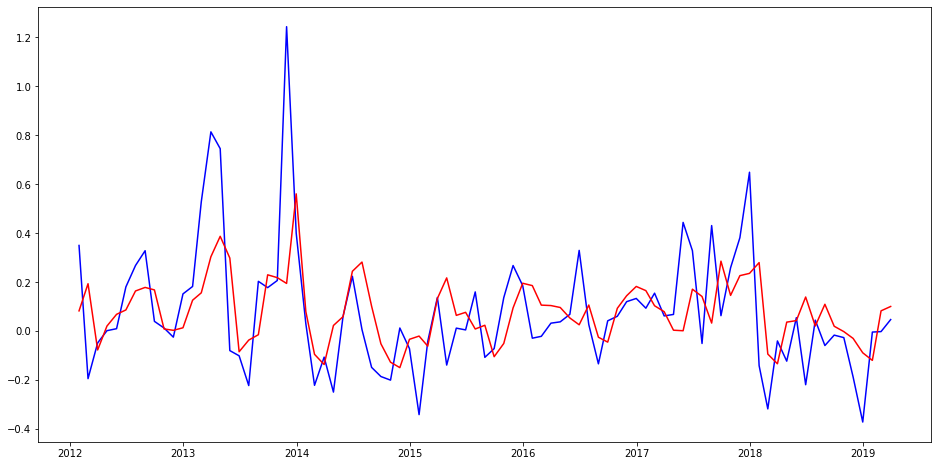

In [22]:
from keras.models import Sequential
from keras.layers import Dense

a = [[1,2,3], [1],[1,2,3]]
params = list(product(*a))

results = []   
min_aic = float('inf')
best_param = []


# checking different set of params for best fit
for param in params:
    try:
        model1 = Sequential()
        model1.add(Dense(1))
        
        model = ARIMA(prices_log, order = param).fit(disp = -1)
    except LinAlgError:
        print('Rejected Parameters:', param)
        continue
    except ValueError:
        print('Rejected Parameters:', param)
        continue
    if(min_aic > model.aic):
        min_aic = model.aic
        best_param = param
        best_model = model
        
    results.append([param, model.aic])

print(best_param,min_aic)
print(results)

print(best_model.fittedvalues)

plt.figure(figsize=(16,8))
sns.lineplot(data = prices_log_r, color = 'blue')
sns.lineplot(data = best_model.fittedvalues, color = 'red')

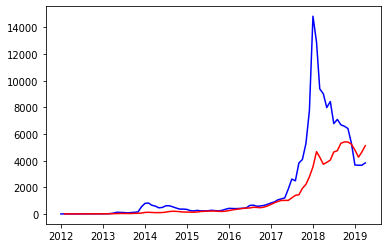

In [14]:
fitted_values = best_model.fittedvalues
fitted_values = fitted_values.cumsum()

fitted_values = fitted_values + prices_log[0]

final_values = np.exp(fitted_values)

d = {'prices' : prices, 'prices_log' : prices_log, 'price_log_r' : prices_log_r, 'fitted_values' : fitted_values, 'final_values' : final_values}
summaryDF = pd.DataFrame(data = d)
sns.lineplot(data = summaryDF['prices'], color = 'blue')
sns.lineplot(data = summaryDF['final_values'], color = 'red')

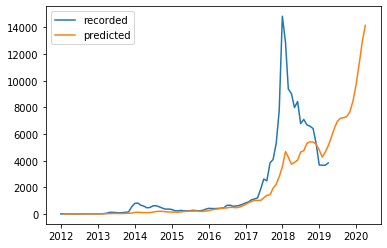

In [15]:
predicted_values = np.exp((best_model.predict(start = 1, end = 99).cumsum()) + prices_log[0])
sns.lineplot(data = prices, label  = 'recorded')
sns.lineplot(data = predicted_values, label = 'predicted')